In [ ]:
"""
Project: Sentiment Analysis on Amazon Electronics Reviews
Models:
- TF-IDF + Logistic Regression (Baseline)
- DistilBERT
- RoBERTa

Goal:
Compare traditional ML and transformer-based models for sentiment classification.
"""

import pandas as pd

path = "data/Electronics.jsonl"

chunks = []
chunk_size = 50_000  

for chunk in pd.read_json(path, lines=True, chunksize=chunk_size):
    chunks.append(chunk)
    if sum(len(c) for c in chunks) >= 100_000:
        break

df = pd.concat(chunks, ignore_index=True).iloc[:100_000]


df = df.rename(columns={
    "text": "review_body",
    "rating": "star_rating",
    "timestamp": "review_date"
})

df = df[["review_body", "star_rating", "review_date"]]

df = df.dropna(subset=["review_body", "star_rating"])
df["star_rating"] = df["star_rating"].astype(int)
df["review_body"] = df["review_body"].astype(str)
df["review_length"] = df["review_body"].str.len()
df["review_date"] = pd.to_datetime(df["review_date"], unit="s", errors="coerce")


def label_sentiment(r):
    if r <= 2:
        return 0   # negative
    elif r == 3:
        return 1   # neutral
    else:
        return 2   # positive

df["sentiment"] = df["star_rating"].apply(label_sentiment)
df["sentiment"].value_counts(normalize=True)

import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r"<.*?>", "", text)     # remove HTML
    text = re.sub(r"http\S+", "", text)   # remove URLs
    text = re.sub(r"[^a-z\s]", "", text)  # keep letters
    return text.strip()

df["clean_review"] = df["review_body"].apply(clean_text)

df = df[df["clean_review"].str.len() > 20]
df = df.sample(
    n=min(100_000, len(df)),
    random_state=42
)
df.to_csv("data/electronics_reviews_clean.csv", index=False)

In [ ]:
import pandas as pd

df = pd.read_csv("data/electronics_reviews_clean.csv")

X = df["clean_review"]
y = df["sentiment"]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1, 2)
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(
    max_iter=1000,
    n_jobs=-1,
    solver="lbfgs",
    multi_class="auto"
)

clf.fit(X_train_tfidf, y_train)

from sklearn.metrics import classification_report, accuracy_score

y_pred = clf.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

import os

os.makedirs("models", exist_ok=True)

import joblib

joblib.dump(tfidf, "models/tfidf.pkl")
joblib.dump(clf, "models/logreg.pkl")

joblib.dump(
    {
        "max_features": 20000,
        "ngram_range": (1, 2),
        "model": "LogisticRegression"
    },
    "models/baseline_config.pkl"
)

In [ ]:
from datasets import Dataset

df = pd.read_csv("data/electronics_reviews_clean.csv")

df = df[["clean_review", "sentiment"]]
df = df.rename(columns={"clean_review": "text", "sentiment": "label"})

dataset = Dataset.from_pandas(df)

dataset = dataset.train_test_split(test_size=0.2, seed=42)

from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3
)

def tokenize(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=256
    )

tokenized_ds = dataset.map(tokenize, batched=True)
tokenized_ds = tokenized_ds.remove_columns(["text"])
tokenized_ds.set_format("torch")

from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    output_dir="results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_steps=100,
    save_strategy="no"
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["test"],
    tokenizer=tokenizer
)

trainer.train()

preds = trainer.predict(tokenized_ds["test"])
y_pred = preds.predictions.argmax(axis=1)
y_true = preds.label_ids

from sklearn.metrics import classification_report, accuracy_score

print("Accuracy:", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

import os
os.makedirs("models/bert_sentiment", exist_ok=True)

model.save_pretrained("models/bert_sentiment")
tokenizer.save_pretrained("models/bert_sentiment")

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

roberta_name = "roberta-base"

roberta_tokenizer = AutoTokenizer.from_pretrained(roberta_name)
roberta_model = AutoModelForSequenceClassification.from_pretrained(
    roberta_name,
    num_labels=3
)

def tokenize_roberta(batch):
    return roberta_tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=256
    )

tokenized_roberta = dataset.map(tokenize_roberta, batched=True)
tokenized_roberta = tokenized_roberta.remove_columns(["text"])
tokenized_roberta.set_format("torch")

from transformers import TrainingArguments, Trainer

roberta_args = TrainingArguments(
    output_dir="results_roberta",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,  
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_steps=100,
    save_strategy="no"
)

roberta_trainer = Trainer(
    model=roberta_model,
    args=roberta_args,
    train_dataset=tokenized_roberta["train"],
    eval_dataset=tokenized_roberta["test"],
    tokenizer=roberta_tokenizer
)

roberta_trainer.train()

roberta_preds = roberta_trainer.predict(tokenized_roberta["test"])

y_pred_roberta = roberta_preds.predictions.argmax(axis=1)
y_true = roberta_preds.label_ids

from sklearn.metrics import classification_report, accuracy_score

print("RoBERTa Accuracy:", accuracy_score(y_true, y_pred_roberta))
print(classification_report(y_true, y_pred_roberta))

roberta_model.save_pretrained("models/roberta_sentiment")
roberta_tokenizer.save_pretrained("models/roberta_sentiment")

                          Model  Accuracy
0  Logistic Regression (TF-IDF)  0.872263
1                    DistilBERT  0.891655
2                       RoBERTa  0.898682


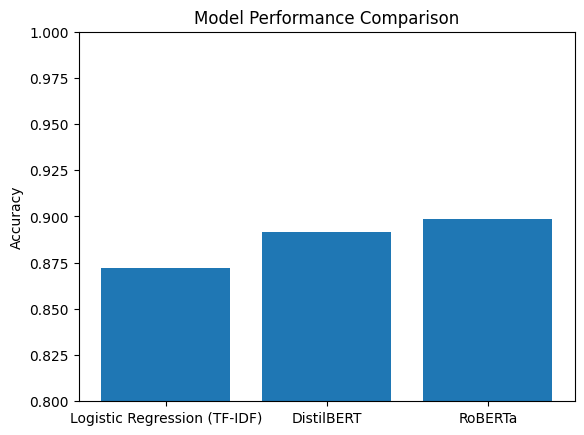

In [23]:
import pandas as pd

results = pd.DataFrame({
    "Model": [
        "Logistic Regression (TF-IDF)",
        "DistilBERT",
        "RoBERTa"
    ],
    "Accuracy": [
        accuracy_score(y_test, clf.predict(X_test_tfidf)),
        accuracy_score(y_true, y_pred),
        accuracy_score(y_true, y_pred_roberta)
    ]
})

print(results)

import matplotlib.pyplot as plt

plt.figure()
plt.bar(results["Model"], results["Accuracy"])
plt.ylabel("Accuracy")
plt.title("Model Performance Comparison")
plt.ylim(0.8, 1.0)
plt.show()

df = pd.read_csv("data/electronics_reviews_clean.csv")

df["review_date"] = pd.to_datetime(df["review_date"])
df = df.sort_values("review_date")


In [24]:
import spacy
from collections import Counter

nlp = spacy.load("en_core_web_sm")

def extract_nouns(texts, n=20):
    nouns = []
    for doc in nlp.pipe(texts, batch_size=50):
        nouns.extend([token.text for token in doc if token.pos_ == "NOUN"])
    return Counter(nouns).most_common(n)

positive_reviews = df[df["sentiment"] == 2]["clean_review"].head(500).tolist()
negative_reviews = df[df["sentiment"] == 0]["clean_review"].head(500).tolist()

print("Top positive aspects:", extract_nouns(positive_reviews))
print("Top negative aspects:", extract_nouns(negative_reviews))

Top positive aspects: [('camera', 412), ('quality', 155), ('sound', 154), ('price', 154), ('time', 151), ('battery', 132), ('player', 129), ('case', 124), ('mouse', 119), ('tv', 105), ('unit', 103), ('card', 99), ('music', 95), ('thing', 94), ('lens', 92), ('one', 92), ('product', 90), ('lot', 85), ('system', 85), ('picture', 82)]
Top negative aspects: [('camera', 167), ('time', 163), ('product', 137), ('quality', 125), ('problem', 105), ('computer', 104), ('drive', 100), ('one', 99), ('unit', 98), ('thing', 91), ('case', 89), ('way', 89), ('screen', 85), ('sound', 84), ('device', 81), ('router', 80), ('video', 78), ('tv', 73), ('cable', 69), ('money', 68)]


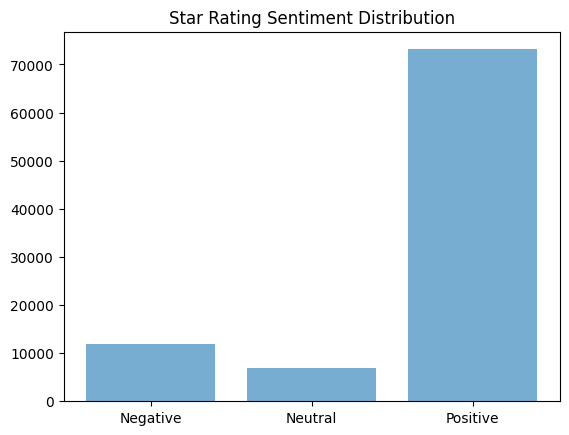

In [25]:
import matplotlib.pyplot as plt

labels = ["Negative", "Neutral", "Positive"]

star_counts = df["sentiment"].value_counts().sort_index()

plt.figure()
plt.bar(labels, star_counts, alpha=0.6)
plt.title("Star Rating Sentiment Distribution")
plt.show()